**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
# Write your code here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

np.random.seed(404)

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [3]:
# firms
A = 1.0
gamma = 0.5

# households
alpha = 0.3
nu = 1.0
epsilon = 2.0

# government
tau = 0.0
T = 0.0

# Question 3
kappa = 0.1

In [4]:
def l_star(p):
    return (p*A*gamma)**(1/(1-gamma))
def y_star(p):
    return A*(l_star(p))**(gamma)
def pi_star(p):
    return ((1-gamma)/(gamma))*(l_star(p))

def utility(c1, c2, L):
    return np.log(c1**alpha*c2**(1-alpha))-nu*(L)**(1+epsilon)/(1+epsilon)

# Consumer's optimal behavior for a given labor supply
def c1_star(L, p1, p2, T):        
        return alpha * (L + T + pi_star(p1) + pi_star(p2)) / p1

def c2_star(L, p1, p2, T, tau):
        return (1 - alpha) * (L + T + pi_star(p1) + pi_star(p2)) / (p2 + tau)

def obj(L, p1, p2, T, tau):
      return np.log((c1_star(L, p1, p2, T))**(alpha) * (c2_star(L, p1, p2, T, tau))**(1-alpha)) - nu * (L**(1+epsilon))/(1+epsilon)

In [5]:
P = (np.linspace(0.1, 2, 10), np.linspace(0.1, 2, 10))
P1 = np.linspace(0.1, 2, 10)
P2 = np.linspace(0.1, 2, 10)

res = []

for p1 in P1:
    for p2 in P2:
        l_star1 = l_star(p1)
        l_star2 = l_star(p2)
        y_star1 = y_star(p1)
        y_star2 = y_star(p2) 

        pi_star1 = pi_star(p1)
        pi_star2 = pi_star(p2)

        res_opt = optimize.minimize(lambda L: -obj(L, p1, p2, T, tau), x0=0, method='BFGS')

        L_star = res_opt.x[0]
        u_star = res_opt.fun

        # Calculate optimal consumption
        c1_star_opt = c1_star(L_star, p1, p2, T)
        c2_star_opt = c2_star(L_star, p1, p2, T, tau)

        # Market clears?
        cond1 = np.isclose(L_star, l_star1 + l_star2)
        cond2 = np.isclose(c1_star_opt, y_star1)
        cond3 = np.isclose(c2_star_opt, y_star2)

        excess_good1 = abs(c1_star_opt - y_star1)
        excess_good2 = abs(c2_star_opt - y_star2)
        excess_labor = abs(L_star - l_star1 - l_star2)

        res.append({
            'p1': p1.round(2),
            'p2': p2.round(2),
            'goods market clearing': (cond2, cond3),
            'utility': u_star,
            'labor': L_star,
            'labor market clearing': cond1,
            'excess goods': (excess_good1.round(2), excess_good2.round(2)),
            'excess labor': excess_labor.round(2)
        })

import pandas as pd

tab1 = pd.DataFrame(res)
tab1

,p1,p2,goods market clearing,utility,labor,labor market clearing,excess goods,excess labor
0,0.1,0.10,"(False, False)",-1.363379,0.998337,False,"(2.96, 6.97)",0.99
1,0.1,0.31,"(False, False)",-0.590364,0.991180,False,"(3.0, 2.13)",0.96
2,0.1,0.52,"(False, False)",-0.270394,0.976987,False,"(3.09, 1.14)",0.91
3,0.1,0.73,"(False, False)",-0.094654,0.956373,False,"(3.23, 0.68)",0.82
4,0.1,0.94,"(False, False)",0.003669,0.930205,False,"(3.42, 0.38)",0.70
...,...,...,...,...,...,...,...,...
95,2.0,1.16,"(False, False)",0.324428,0.701025,False,"(0.69, 0.65)",0.63
96,2.0,1.37,"(False, False)",0.378232,0.682140,False,"(0.68, 0.42)",0.78
97,2.0,1.58,"(False, False)",0.408647,0.661682,False,"(0.66, 0.22)",0.96
98,2.0,1.79,"(False, False)",0.421295,0.640165,False,"(0.63, 0.06)",1.16


In [6]:
idx_goods = tab1['excess goods'].min()
tab1[tab1['excess goods']==idx_goods]

,p1,p2,goods market clearing,utility,labor,labor market clearing,excess goods,excess labor
46,0.94,1.37,"(False, False)",0.584075,0.815123,False,"(0.01, 0.09)",0.13


**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [7]:
# For which p1, p2 has the lowest market clearing error?
idx_goods = tab1['excess goods'].min()
p1_star, p2_star = tab1[tab1['excess goods']==idx_goods].loc[:, ['p1', 'p2']].values[0]
L_star_opt = tab1[tab1['excess goods']==idx_goods].loc[:, ['labor']].values[0]

print(f'Prices (p1, p2)=({p1_star:.2f}, {p2_star:.2f}) has the lowest market clearing error and is thus the equilibrium prices.')

Prices (p1, p2)=(0.94, 1.37) has the lowest market clearing error and is thus the equilibrium prices.


Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In [8]:
def obj_gov(tau):

      # Calculate optimal consumption
      c1_star_new = c1_star(L_star_opt, p1_star, p2_star, T=tau*c2_star_opt)
      c2_star_new = c2_star(L_star_opt, p1_star, p2_star, T=tau*c2_star_opt, tau=tau)

      util = np.log((c1_star_new)**(alpha) * (c2_star_new)**(1-alpha)) - nu * (L_star_opt**(1+epsilon))/(1+epsilon)

      SWF = util - kappa*y_star(p2_star)

      return -SWF

def constraint(tau):
      c2_star_opt = c2_star(L_star_opt, p1_star, p2_star, T, tau)
      return T - tau * c2_star_opt 

constraints = [{
      'type': 'eq',
      'fun': constraint
}]

res_opt = optimize.minimize(obj_gov, x0=0.1, bounds=[(0, 10)], constraints=constraints)
res_opt.x

array([0.])

In [9]:
def obj_gov2(X):
      L, p1, p2, T, tau = X

      c1_star_opt = c1_star(L, p1, p2, T)
      c2_star_opt = c2_star(L, p1, p2, T, tau)
      
      util = np.log((c1_star_opt)**(alpha) * (c2_star_opt)**(1-alpha)) - nu * (L**(1+epsilon))/(1+epsilon)

      SWF = util - kappa*y_star(p2)

      return -SWF

def constraint(X):
      L, p1, p2, T, tau = X

      c2_star_opt = c2_star(L, p1, p2, T, tau)
      
      return T - tau * c2_star_opt 

constraints = [{
      'type': 'eq',
      'fun': constraint
}]

res_opt = optimize.minimize(obj_gov2, x0=(0.1, 0.1, 0.1, 0.1, 0.1), bounds=[(0, 1), (0.1, 2), (0.1, 2), (0.1, 10), (0.1, 10)], constraints=constraints)
X = res_opt.x
X

array([0.99833609, 0.1       , 0.1       , 0.54025789, 0.1       ])

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [10]:
J = 3
N = 10
K = 10000

F = np.arange(1,N+1)
sigma = 2

v = np.array([1,2,3])
c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


In [11]:
eps_ijk = np.random.normal(0, sigma, size=J*K).reshape(J, K)
eps_ijk

array([[-2.36538178,  2.67492331, -0.62861009, ...,  2.01242852,
        -1.54397321, -0.6658964 ],
       [ 2.4370702 ,  2.75002318, -2.15752169, ..., -1.09507763,
        -0.54499186, -1.08489749],
       [ 1.27185747, -0.46142368, -0.64704088, ..., -3.08235234,
         2.47588745, -0.07465394]])

In [12]:
res = []

res.append({
    'u1': v[0] + np.mean(eps_ijk[0, :]),
    'u2': v[1] + np.mean(eps_ijk[1, :]),
    'u3': v[2] + np.mean(eps_ijk[2, :])
})

tab3 = pd.DataFrame(res)
tab3

,u1,u2,u3
0,0.973458,1.996285,2.989331


Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

In [234]:
res = []

helper_idx = np.arange(K)

for i in range(N): 
    eps_fjk = np.random.normal(0, sigma, size = J * F[i] * K).reshape(F[i], J, K) # F[i], J, K
    u_bar_ijk = 1/F[i] * (v.reshape(-1,1) + eps_fjk.sum(axis=0)) # J, K
    career_choice = u_bar_ijk.argmax(axis=0) # K
    util_prior = u_bar_ijk[career_choice, helper_idx] # J, K
    eps_ijk = np.random.normal(0, sigma, size=J * K).reshape(J, K) # J, K
    util_real = v[career_choice] + eps_ijk[career_choice, :].mean()
    grad = i+1

    res.append({
            'career': (career_choice+1),
            'util_prior': util_prior,
            'util_real': util_real,
            'grad_i': grad 
        })

tab4 = pd.DataFrame(res)
tab4

,career,util_prior,util_real,grad_i
0,"[2, 3, 3, 3, 3, 3, 3, 3, 2, 1, 2, 1, 2, 1, 2, ...","[3.3108835352105155, 4.20118210988239, 5.94991...","[1.9925377430949995, 2.9925377430949993, 2.992...",1
1,"[1, 1, 3, 3, 3, 2, 3, 1, 3, 2, 1, 3, 1, 3, 1, ...","[0.7370522778712522, 1.0843960132517236, 4.178...","[0.9880159164868105, 0.9880159164868105, 2.988...",2
2,"[1, 2, 3, 3, 2, 3, 2, 1, 3, 3, 1, 3, 2, 3, 3, ...","[2.4014597054088274, 2.2528301454728994, 0.818...","[0.9875698551733527, 1.9875698551733527, 2.987...",3
3,"[1, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 1, 2, 1, 2, ...","[1.5443692671056448, 2.6162537171564537, 0.496...","[1.0059259421357836, 2.0059259421357836, 3.005...",4
4,"[2, 3, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2, ...","[1.7592739833335118, 0.38504942044377855, 1.55...","[1.993928141647685, 2.993928141647685, 1.99392...",5
5,"[2, 1, 2, 2, 3, 1, 2, 3, 2, 2, 2, 3, 1, 2, 3, ...","[0.3315851219073169, 0.7344350505665972, 1.208...","[2.0060571986984974, 1.0060571986984974, 2.006...",6
6,"[3, 1, 1, 2, 1, 2, 2, 2, 1, 3, 1, 3, 1, 3, 3, ...","[0.7743404516688919, 0.6809841128568793, 1.128...","[3.0161313475944143, 1.0161313475944143, 1.016...",7
7,"[2, 3, 3, 1, 3, 2, 2, 1, 3, 1, 2, 2, 2, 2, 2, ...","[0.636788998332241, 0.2668689254599331, 0.7822...","[2.008445548917064, 3.008445548917064, 3.00844...",8
8,"[1, 1, 2, 3, 1, 2, 3, 3, 1, 3, 1, 2, 2, 2, 1, ...","[1.2106087119016284, 0.9902741419302964, 2.016...","[1.025592665636013, 1.025592665636013, 2.02559...",9
9,"[3, 1, 1, 3, 2, 2, 3, 1, 3, 1, 3, 3, 1, 1, 1, ...","[0.11962692567936671, 1.0254443107369808, 0.75...","[2.9707431914395976, 0.9707431914395976, 0.970...",10


In [235]:
tab4_long = tab4.explode(['career', 'util_prior', 'util_real']).reset_index(drop=True)
tab4_long.head()

,career,util_prior,util_real,grad_i
0,2,3.310884,1.992538,1
1,3,4.201182,2.992538,1
2,3,5.949913,2.992538,1
3,3,3.625534,2.992538,1
4,3,4.393684,2.992538,1


In [236]:
tab4_long.groupby('grad_i').mean().reset_index()

,grad_i,career,util_prior,util_real
0,1,2.4069,3.87526,2.399438
1,2,2.2668,2.267164,2.254816
2,3,2.2476,1.676682,2.23517
3,4,2.2211,1.374027,2.227026
4,5,2.1756,1.181433,2.169528
5,6,2.1765,1.042631,2.182557
6,7,2.1588,0.938185,2.174931
7,8,2.1364,0.858893,2.144846
8,9,2.1461,0.785524,2.171693
9,10,2.1275,0.735254,2.098243


In [237]:
careers_by_grad=tab4_long.value_counts(['career', 'grad_i']).reset_index().sort_values('grad_i').reset_index(drop=True)
careers_by_grad['share']=careers_by_grad['count']/K
careers_by_grad

,career,grad_i,count,share
0,3,1,5550,0.5550
1,2,1,2969,0.2969
2,1,1,1481,0.1481
3,2,2,3236,0.3236
4,3,2,4716,0.4716
5,1,2,2048,0.2048
6,1,3,2128,0.2128
7,3,3,4604,0.4604
8,2,3,3268,0.3268
9,1,4,2304,0.2304


In [238]:
temp=careers_by_grad[careers_by_grad['grad_i']==1]['share']

In [239]:
temp

0    0.5550
1    0.2969
2    0.1481
Name: share, dtype: float64

In [246]:
temp2=tab4_long.groupby('grad_i').mean().reset_index()
temp2

,grad_i,career,util_prior,util_real
0,1,2.4069,3.87526,2.399438
1,2,2.2668,2.267164,2.254816
2,3,2.2476,1.676682,2.23517
3,4,2.2211,1.374027,2.227026
4,5,2.1756,1.181433,2.169528
5,6,2.1765,1.042631,2.182557
6,7,2.1588,0.938185,2.174931
7,8,2.1364,0.858893,2.144846
8,9,2.1461,0.785524,2.171693
9,10,2.1275,0.735254,2.098243


In [248]:
util_prior_mean = temp2[temp2['grad_i']==1]['util_prior'][0]
util_prior_mean

3.87525977760748

In [249]:
util_real_mean = temp2[temp2['grad_i']==1]['util_real'][0]
util_real_mean

2.3994377430953753

In [259]:
util_pre = tab4_long[tab4_long['grad_i']==1]['util_prior']

Text(0, 0.5, 'Density')

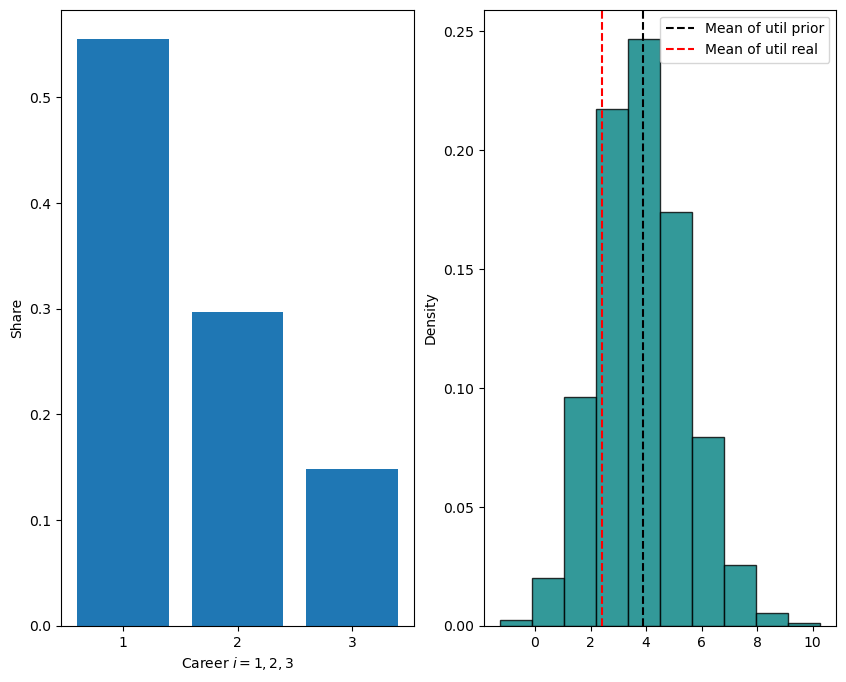

In [274]:
fig, ax = plt.subplots(1, 2, figsize=(10,8))
ax[0].bar([1, 2, 3], temp)
ax[1].hist(util_pre, density=True, bins=10, edgecolor='k', alpha=0.8, color='teal')
ax[1].axvline(util_prior_mean, color='k', linestyle='--', label='Mean of util prior')
ax[1].axvline(util_real_mean, color='r', linestyle='--', label='Mean of util real')
ax[1].legend()
ax[0].set_xlabel(r'Career $i=1, 2, 3$')
ax[0].set_xticks([1, 2, 3])
ax[0].set_ylabel('Share')
ax[1].set_ylabel('Density')

In [288]:
temp2

,grad_i,career,util_prior,util_real
0,1,2.4069,3.87526,2.399438
1,2,2.2668,2.267164,2.254816
2,3,2.2476,1.676682,2.23517
3,4,2.2211,1.374027,2.227026
4,5,2.1756,1.181433,2.169528
5,6,2.1765,1.042631,2.182557
6,7,2.1588,0.938185,2.174931
7,8,2.1364,0.858893,2.144846
8,9,2.1461,0.785524,2.171693
9,10,2.1275,0.735254,2.098243


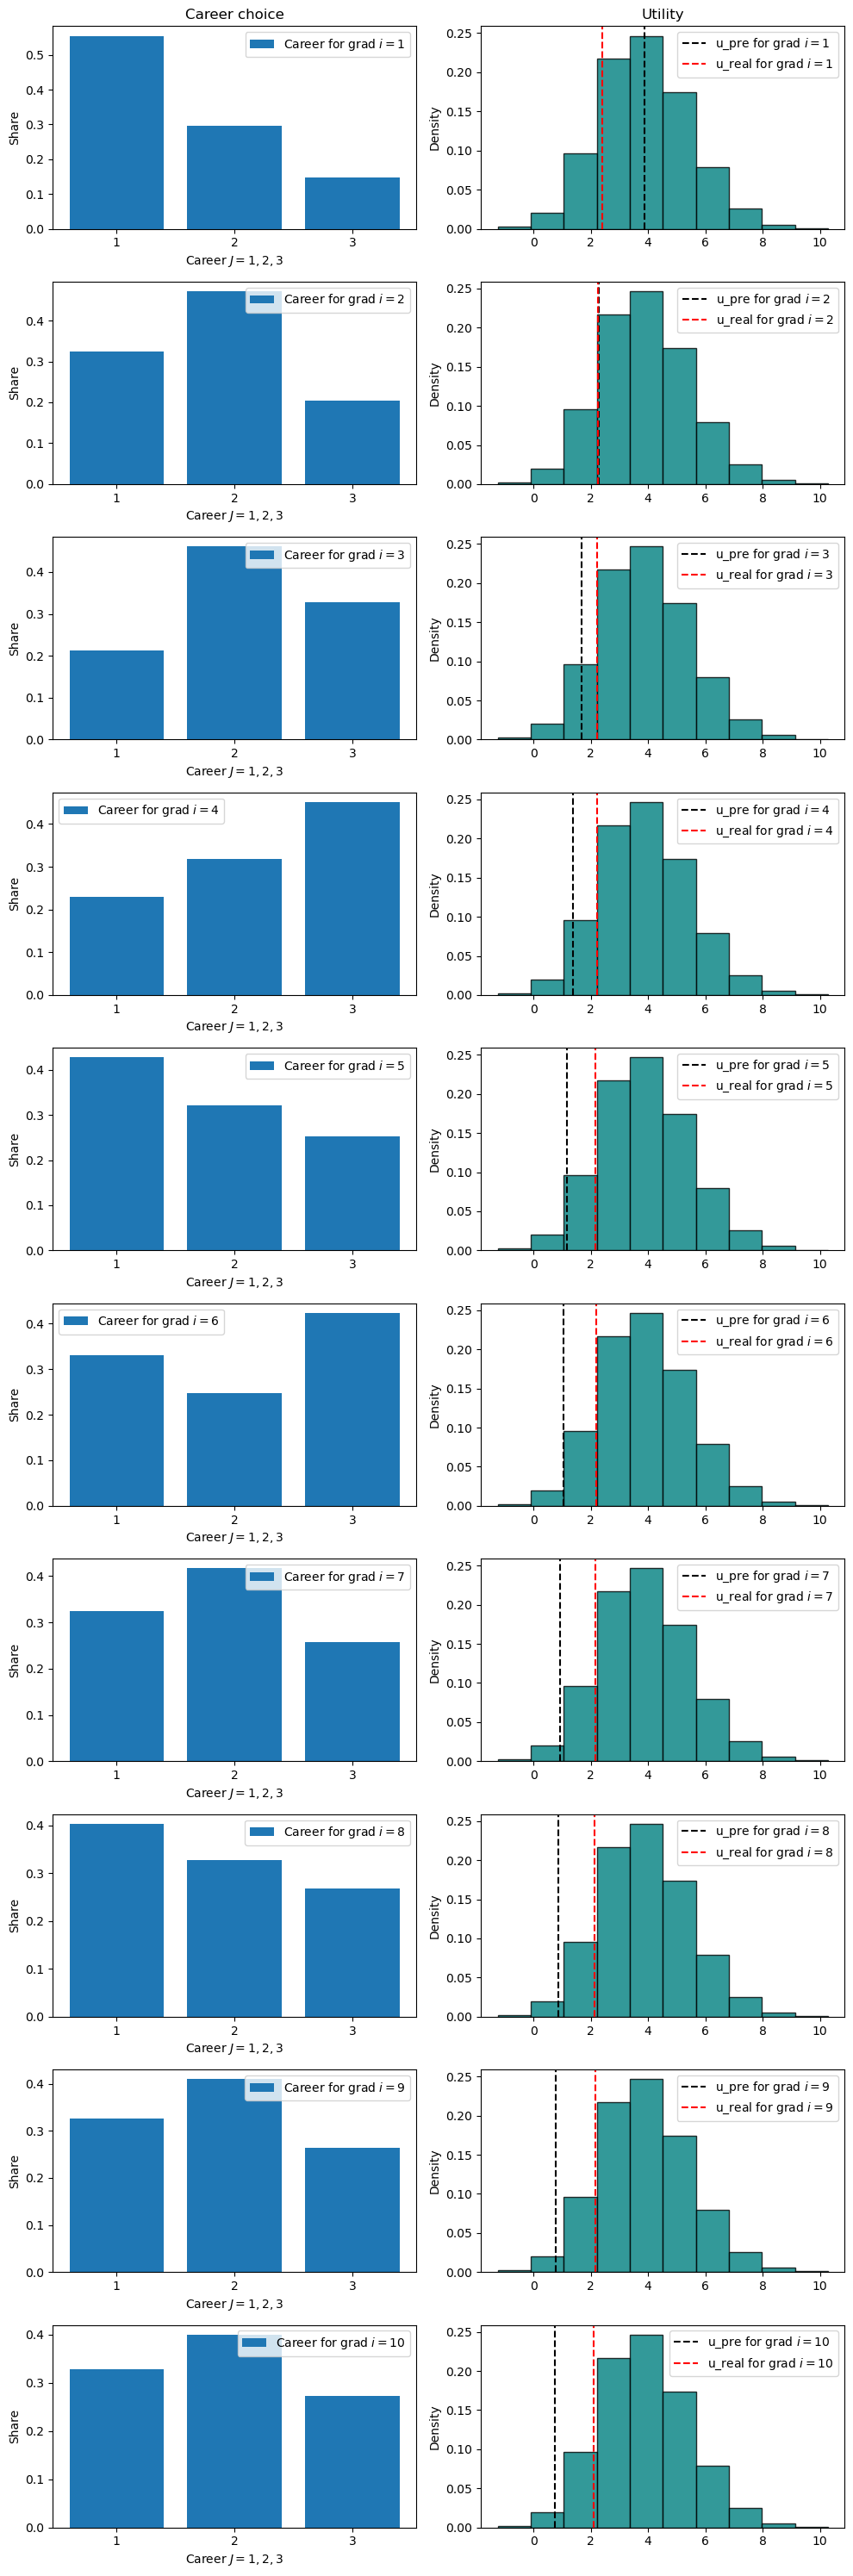

In [297]:
fig, ax = plt.subplots(N, 2, figsize=(10,30), tight_layout=True)

res_groupby_grad = tab4_long.groupby('grad_i').mean().reset_index()

for i in range(N):

    util_prior_mean = res_groupby_grad[res_groupby_grad['grad_i']==i+1]['util_prior'][i]
    util_real_mean = res_groupby_grad[res_groupby_grad['grad_i']==i+1]['util_real'][i]
    career_J = careers_by_grad[careers_by_grad['grad_i']==i+1]['share']

    ax[0, 0].set_title('Career choice')
    ax[0, 1].set_title('Utility')

    ax[i, 0].bar([1, 2, 3], career_J, label=f'Career for grad $i={i+1}$')
    ax[i, 1].hist(util_pre, density=True, bins=10, edgecolor='k', alpha=0.8, color='teal')
    ax[i, 1].axvline(util_prior_mean, color='k', linestyle='--', label=f'u_pre for grad $i={i+1}$')
    ax[i, 1].axvline(util_real_mean, color='r', linestyle='--', label=f'u_real for grad $i={i+1}$')
    ax[i, 1].legend()
    ax[i, 0].legend()
    ax[i, 0].set_xlabel(r'Career $J=1, 2, 3$')
    ax[i, 0].set_xticks([1, 2, 3])
    ax[i, 0].set_ylabel('Share')
    ax[i, 1].set_ylabel('Density')

After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

In [23]:
# write your answer here

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [46]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


In [47]:
y

array([0.20901926, 0.37774759])

**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

In [48]:
def obj_sq(X):
    return np.sqrt((X[0]-y[0])**2 + (X[1]-y[1])**2)

err = 0.01

# x1 > y1
def constraint_1_1(X):
    return X[0]-y[0]-err

# y1 > x1
def constraint_1_2(X):
    return y[0]-X[0]-err

# x2 > y2
def constraint_2_1(X):
    return X[1] - y[1]-err

# y2 > x2
def constraint_2_2(X):
    return y[1] - X[1]-err

# x1 > y1 & x2 > y2
constraints_A = [{'type': 'ineq', 'fun': constraint_1_1},
               {'type': 'ineq', 'fun': constraint_2_1}] 

# x1 > y1 & x2 < y2
constraints_B = [{'type': 'ineq', 'fun': constraint_1_1},
               {'type': 'ineq', 'fun': constraint_2_2}] 

# x1 < y1 & x2 < y2
constraints_C = [{'type': 'ineq', 'fun': constraint_1_2},
               {'type': 'ineq', 'fun': constraint_2_2}] 

# x1 < y1 & x2 > y2
constraints_D = [{'type': 'ineq', 'fun': constraint_1_2},
               {'type': 'ineq', 'fun': constraint_2_1}] 

res_A=optimize.minimize(obj_sq, x0=(0.1,0.1), constraints=constraints_A)
A = res_A.x
x1A, x2A = A

res_B=optimize.minimize(obj_sq, x0=(0.1,0.1), constraints=constraints_B)
B = res_B.x
x1B, x2B = B

res_C=optimize.minimize(obj_sq, x0=(0.1,0.1), constraints=constraints_C)
C = res_C.x
x1C, x2C = C

res_D=optimize.minimize(obj_sq, x0=(0.1,0.1), constraints=constraints_D)
D = res_D.x
x1D, x2D = D

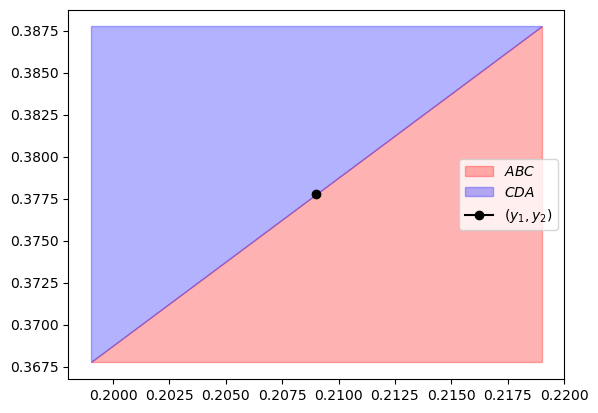

In [61]:
fig, ax = plt.subplots()

ax.fill([x1A, x1B, x1C], [x2A, x2B, x2C], color='r', alpha=0.3, label=r'$ABC$')
ax.fill([x1C, x1D, x1A], [x2C, x2D, x2A], color='b', alpha=0.3, label=r'$CDA$')
ax.plot(y[0], y[1], marker='o', color='black', label=fr'$(y_1, y_2)$')
ax.legend()

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

In [66]:
def bary_coords(X1, X2, X3, y):

    r1 = ((X2[1]-X3[1])*(y[0]-X3[0])+(X3[0]-X2[0])*(y[1]-X3[1]))/((X2[1]-X3[1])*(X1[0]-X3[0])+(X3[0]-X2[0])*(X1[1]-X3[1]))

    r2 = ((X3[1]-X1[1])*(y[0]-X3[0])+(X1[0]-X3[0])*(y[1]-X3[1]))/((X2[1]-X3[1])*(X1[0]-X3[0])+(X3[0]-X2[0])*(X1[1]-X3[1]))

    r3 = 1-r1-r2

    return r1, r2, r3

ABC_coords = bary_coords(A, B, C, y)
CDA_coords = bary_coords(C, D, A, y)

def check_coords(coords):
    coords = np.array([coords])
    return np.all((coords >= 0) & (coords <=1))

y0, y1 = y

if check_coords(ABC_coords)==True:
    print(f'the points y = ({y0:.2f}, {y1:.2f}) is in triangle ABC')
elif check_coords(CDA_coords)==True:
    print(f'the points y = ({y0:.2f}, {y1:.2f}) is in triangle CDA')

the points y = (0.21, 0.38) is in triangle CDA


Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [31]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

In [32]:
def check_coords(coords):
    coords = np.array([coords])
    return np.all((coords >= 0) & (coords <=1))

In [33]:
def bary_interp(X, y, f):
    res_A=optimize.minimize(obj_sq, x0=(0.1,0.1), constraints=constraints_A)
    A = res_A.x
    x1A, x2A = A

    res_B=optimize.minimize(obj_sq, x0=(0.1,0.1), constraints=constraints_B)
    B = res_B.x
    x1B, x2B = B

    res_C=optimize.minimize(obj_sq, x0=(0.1,0.1), constraints=constraints_C)
    C = res_C.x
    x1C, x2C = C

    res_D=optimize.minimize(obj_sq, x0=(0.1,0.1), constraints=constraints_D)
    D = res_D.x
    x1D, x2D = D
    
    ABC_coords = bary_coords(A, B, C, y)
    CDA_coords = bary_coords(C, D, A, y)

    if check_coords(ABC_coords)==True:
        r1, r2, r3 = ABC_coords
        return r1 * f(A) + r2 * f(B) + r3 * f(C)
    elif check_coords(CDA_coords)==True:
        r1, r2, r3 = CDA_coords
        return r1 * f(C) + r2 * f(D) + r3 * f(A)

In [67]:
bary_interp(X, y, f)

0.07905652162595939

In [68]:
f(y)

0.0789565216259594

**Question 4:** Repeat question 3 for all points in the set $Y$.

In [36]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

In [37]:
res = []

for y in Y:
    interp_val = bary_interp(X, y, f)
    true_val = f(y)
    y1, y2 = y
    res.append({
        'Interpolated': interp_val,
        'True': true_val,
        '(y1, y2)': (y1, y2)
    })

tab5 = pd.DataFrame(res)
tab5

,Interpolated,True,"(y1, y2)"
0,0.0401,0.04,"(0.2, 0.2)"
1,0.1601,0.16,"(0.8, 0.2)"
2,0.6401,0.64,"(0.8, 0.8)"
3,0.1601,0.16,"(0.8, 0.2)"
4,0.2501,0.25,"(0.5, 0.5)"
